# Binary Classification with Neural Networks

This notebook covers the fundamentals of building and training neural networks in PyTorch for binary classification. I started with a simple dataset to understand the basics, then scaled up to classifying handwritten digits.

**Topics covered:**
- Building models with `nn.Module` and `nn.Sequential`
- Manual forward pass with `torch.matmul` (what `nn.Linear` actually does)
- Training loops, loss functions, and optimizers
- Model evaluation with ROC curves and AUC

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Part 1: Simple Binary Classification (Portraits vs Landscapes)

Classification of a simple dataset of image features to classify portraits vs landscapes.

In [4]:
data = pd.read_csv("data/portraits_and_scenes.csv")
print(f"Dataset shape: {data.shape}")
print(f"Class distribution:\n{data['class'].value_counts()}")

Dataset shape: (300, 4)
Class distribution:
class
0    150
1    150
Name: count, dtype: int64


In [5]:
X = data.drop("class", axis=1).values
y = data["class"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=42, stratify=y
)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

n_features = X_train.shape[1]
print(f"Train: {X_train_t.shape[0]} samples, {n_features} features")
print(f"Test: {X_test_t.shape[0]} samples")

Train: 200 samples, 3 features
Test: 100 samples


### Model using nn.Linear

A simple two-layer network: input → 8 hidden units → 1 output.

In [6]:
class SimpleModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

model = SimpleModel(n_features).to(device)
print(model)

SimpleModel(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


### Manual Forward Pass

To understand what `nn.Linear` actually does, here's the same model implemented manually using `torch.matmul`. A linear layer computes: `output = input @ W.T + bias`

In [7]:
class ManualModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        # Layer 1: n_features -> 8
        self.W1 = nn.Parameter(torch.randn(8, n_features) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(8))
        # Layer 2: 8 -> 1
        self.W2 = nn.Parameter(torch.randn(1, 8) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        # Layer 1 + ReLU
        z1 = torch.matmul(x, self.W1.T) + self.b1
        a1 = torch.relu(z1)
        # Layer 2 + Sigmoid
        z2 = torch.matmul(a1, self.W2.T) + self.b2
        return torch.sigmoid(z2).squeeze(-1)

manual_model = ManualModel(n_features).to(device)
print(f"Manual model parameters: {sum(p.numel() for p in manual_model.parameters())}")
print(f"SimpleModel parameters: {sum(p.numel() for p in model.parameters())}")

Manual model parameters: 41
SimpleModel parameters: 41


### Training

In [8]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).float().mean() * 100

def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.001, print_every=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        model.train()
        pred = model(X_train)
        loss = loss_fn(pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            model.eval()
            with torch.no_grad():
                train_acc = accuracy(y_train, (pred > 0.5).float())
                test_pred = model(X_test)
                test_acc = accuracy(y_test, (test_pred > 0.5).float())
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.4f} | Train Acc: {train_acc:.1f}% | Test Acc: {test_acc:.1f}%")

    return model

In [9]:
print("Training nn.Linear model:")
model = train_model(SimpleModel(n_features).to(device), X_train_t, y_train_t, X_test_t, y_test_t)

Training nn.Linear model:
Epoch    0 | Loss: 0.6769 | Train Acc: 50.0% | Test Acc: 50.0%
Epoch  200 | Loss: 0.5197 | Train Acc: 87.5% | Test Acc: 89.0%
Epoch  400 | Loss: 0.3567 | Train Acc: 88.5% | Test Acc: 89.0%
Epoch  600 | Loss: 0.2830 | Train Acc: 88.0% | Test Acc: 89.0%
Epoch  800 | Loss: 0.2521 | Train Acc: 88.0% | Test Acc: 90.0%


In [10]:
print("\nTraining manual matmul model:")
manual_model = train_model(ManualModel(n_features).to(device), X_train_t, y_train_t, X_test_t, y_test_t)


Training manual matmul model:
Epoch    0 | Loss: 0.6932 | Train Acc: 44.5% | Test Acc: 50.0%
Epoch  200 | Loss: 0.5736 | Train Acc: 89.0% | Test Acc: 85.0%
Epoch  400 | Loss: 0.3814 | Train Acc: 89.0% | Test Acc: 87.0%
Epoch  600 | Loss: 0.2876 | Train Acc: 90.5% | Test Acc: 91.0%
Epoch  800 | Loss: 0.2514 | Train Acc: 89.0% | Test Acc: 91.0%


Both models achieve similar accuracy, confirming the manual implementation is correct.

---

## Part 2: MNIST Digit Classification (1 vs 7)

Now we scale up to real image data: classifying handwritten 1s vs 7s from MNIST.

In [11]:
transform = transforms.ToTensor()

train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_full = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Filter for 1s and 7s only
train_idx = [i for i, (_, y) in enumerate(train_full) if y in (1, 7)]
test_idx = [i for i, (_, y) in enumerate(test_full) if y in (1, 7)]

train_data = Subset(train_full, train_idx)
test_data = Subset(test_full, test_idx)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.05MB/s]


Training samples: 13007
Test samples: 2163


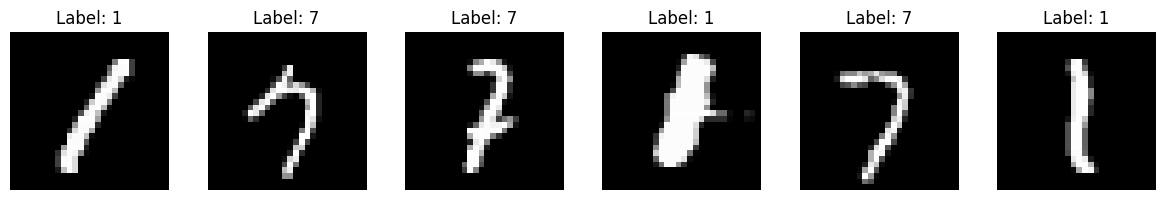

In [12]:
# Visualization of a few examples
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i, ax in enumerate(axes):
    img, label = train_data[i * 100]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

def relabel(y):
    """Convert labels: 7 -> 1, 1 -> 0"""
    return (y == 7).float()

In [14]:
class MNISTBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x).squeeze(-1)

model = MNISTBinaryClassifier().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [15]:
for epoch in range(5):
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), relabel(y).to(device)
        logits = model(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), relabel(y).to(device)
            probs = torch.sigmoid(model(X))
            preds = (probs > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.numel()
    print(f"Epoch {epoch+1}: Test accuracy = {100*correct/total:.2f}%")

Epoch 1: Test accuracy = 98.61%
Epoch 2: Test accuracy = 98.98%
Epoch 3: Test accuracy = 99.12%
Epoch 4: Test accuracy = 99.17%
Epoch 5: Test accuracy = 99.17%


### ROC Curve and AUC

Accuracy alone doesn't tell the full story. The ROC curve shows the tradeoff between true positive rate and false positive rate at different classification thresholds.

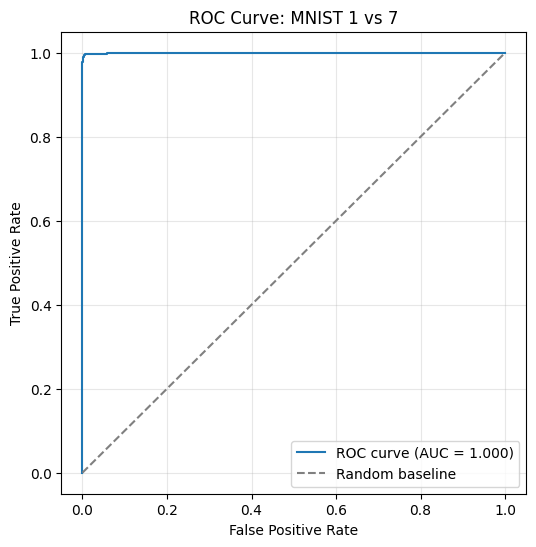

AUC: 0.9997


In [16]:
model.eval()
all_probs, all_labels = [], []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), relabel(y).to(device)
        probs = torch.sigmoid(model(X))
        all_probs.append(probs.cpu())
        all_labels.append(y.cpu())

all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: MNIST 1 vs 7")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC: {auc:.4f}")

## Summary

- Built neural networks using both `nn.Linear` and manual `torch.matmul` implementations
- Trained binary classifiers on tabular data and image data
- Evaluated models using accuracy, ROC curves, and AUC
- The high AUC (close to 1.0) shows that 1s and 7s are easily separable - which makes sense, as they look quite different